[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds4v/absa-vlsp-2018/blob/main/experiments/Hotel-v1.ipynb)

In [ ]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q accelerate
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires 

In [1]:
!git clone https://github.com/trunghieu41003/Big-data-project.git
!ls

Cloning into 'Big-data-project'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 73 (delta 26), reused 46 (delta 8), pack-reused 0
Receiving objects: 100% (73/73), 25.40 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Big-data-project  sample_data


In [2]:
import os
import shutil

# Kiểm tra cấu trúc thư mục hiện tại
print("Trước khi di chuyển:")
!ls /content

# Đường dẫn thư mục hiện tại
current_folder = "/content/Big-data-project"

# Đường dẫn đích đến
destination_folder = "/content"

# Lặp qua từng thư mục con trong thư mục hiện tại
for item in os.listdir(current_folder):
    # Tạo đường dẫn đầy đủ tới mỗi thư mục con
    current_path = os.path.join(current_folder, item)
    # Di chuyển thư mục con đến đích đến
    shutil.move(current_path, destination_folder)

# Kiểm tra lại cấu trúc thư mục sau khi di chuyển
print("\nSau khi di chuyển:")
!ls /content

Trước khi di chuyển:
Big-data-project  sample_data

Sau khi di chuyển:
acsa_model.py  Big-data-project  evaluators   helper.py  processors  sample_data
assests        datasets		 experiments  Paper.pdf  README.md


In [ ]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append('..')
tf.__version__

'2.15.0'

In [ ]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Constants Setup and Load the Data

In [ ]:
TRAIN_PATH = 'datasets/vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv'
VAL_PATH = 'datasets/vlsp2018_hotel/2-VLSP2018-SA-Hotel-dev.csv'
TEST_PATH = 'datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv'
MODEL_NAME = 'Hotel-v1' # Multitask model on Hotel domain
MAX_LENGTH = 256
BATCH_SIZE = 25
EPOCHS = 20

In [ ]:
from processors.vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATUR

# Preprocess and Tokenize the Data

In [ ]:
from processors.vietnamese_processor import VietnameseTextPreprocessor

# You should be carefull when using single word replacement for acronyms, because it can cause misinterpretation.
# For example, 'giá': ['price', 'gia'] can replace the word 'gia' in 'gia đình', making it become 'giá đình'.
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processors/VnCoreNLP', extra_teencodes={
    'khách sạn': ['ks'], 'nhà hàng': ['nhahang'], 'nhân viên': ['nv'],
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

VnCoreNLP word segmenter is loaded successfully.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

bmd1905/vietnamese-correction-v2 is loaded successfully.


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .')
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2] 
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
# preprocessed_datasets.save_to_disk('../datasets/preprocessed_hotel')
# display(preprocessed_datasets)
# pd.DataFrame({
#     'raw_datasets': raw_datasets['train']['Review'][1480:1490],
#     'encoded_input_ids': preprocessed_datasets['train']['input_ids'][1480:1490],
#     'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(1480, 1490)]
# })

In [ ]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('../datasets/preprocessed_hotel')
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFOR

# Prepare for TensorFlow Training

In [ ]:
# Tensorflow only accepts targeted column names prefixed with 'output_'
MULTI_BRANCH_NAMES = {old_name: f'output_{i + 1}' for i, old_name in enumerate(raw_datasets['train'].column_names[1:])}
preprocessed_datasets = preprocessed_datasets.rename_columns(MULTI_BRANCH_NAMES)
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(MULTI_BRANCH_NAMES)

{'FACILITIES#CLEANLINESS': 'output_1', 'FACILITIES#COMFORT': 'output_2', 'FACILITIES#DESIGN&FEATURES': 'output_3', 'FACILITIES#GENERAL': 'output_4', 'FACILITIES#MISCELLANEOUS': 'output_5', 'FACILITIES#PRICES': 'output_6', 'FACILITIES#QUALITY': 'output_7', 'FOOD&DRINKS#MISCELLANEOUS': 'output_8', 'FOOD&DRINKS#PRICES': 'output_9', 'FOOD&DRINKS#QUALITY': 'output_10', 'FOOD&DRINKS#STYLE&OPTIONS': 'output_11', 'HOTEL#CLEANLINESS': 'output_12', 'HOTEL#COMFORT': 'output_13', 'HOTEL#DESIGN&FEATURES': 'output_14', 'HOTEL#GENERAL': 'output_15', 'HOTEL#MISCELLANEOUS': 'output_16', 'HOTEL#PRICES': 'output_17', 'HOTEL#QUALITY': 'output_18', 'LOCATION#GENERAL': 'output_19', 'ROOMS#CLEANLINESS': 'output_20', 'ROOMS#COMFORT': 'output_21', 'ROOMS#DESIGN&FEATURES': 'output_22', 'ROOMS#GENERAL': 'output_23', 'ROOMS#MISCELLANEOUS': 'output_24', 'ROOMS#PRICES': 'output_25', 'ROOMS#QUALITY': 'output_26', 'ROOM_AMENITIES#CLEANLINESS': 'output_27', 'ROOM_AMENITIES#COMFORT': 'output_28', 'ROOM_AMENITIES#DESIGN

In [ ]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=list(MULTI_BRANCH_NAMES.values()),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=list(MULTI_BRANCH_NAMES.values()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=list(MULTI_BRANCH_NAMES.values()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True, # You may obtain HIGHER metrics on the test set with longer training time if you set this to False
    # Because after some experiments, I found that even with higher val_loss, it still results in better metric reports on the test set.
    # This maybe because the training set and the test set have more similarities than the validation data.
    # But I think this is not fair, as we already have prior knowledge about the test set and we modified our training based on the performance on this set.
    # In real-world, we should only modify our training based on the performance on the validation data
    verbose = 1
)

# Fine-tuning with TensorFlow

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


120/120 [==============================] - 349s 2s/step - loss: 13.7395 - output_1_loss: 0.2637 - output_2_loss: 0.2390 - output_3_loss: 0.5920 - output_4_loss: 0.3293 - output_5_loss: 0.1103 - output_6_loss: 0.1319 - output_7_loss: 0.3248 - output_8_loss: 0.0808 - output_9_loss: 0.2342 - output_10_loss: 0.6620 - output_11_loss: 0.6106 - output_12_loss: 0.4344 - output_13_loss: 0.7190 - output_14_loss: 0.7600 - output_15_loss: 0.8597 - output_16_loss: 0.2317 - output_17_loss: 0.5613 - output_18_loss: 0.3580 - output_19_loss: 0.8532 - output_20_loss: 0.6112 - output_21_loss: 0.4984 - output_22_loss: 0.7842 - output_23_loss: 0.3726 - output_24_loss: 0.0577 - output_25_loss: 0.3104 - output_26_loss: 0.2893 - output_27_loss: 0.1740 - output_28_loss: 0.1982 - output_29_loss: 0.4412 - output_30_loss: 0.3374 - output_31_loss: 0.0658 - output_32_loss: 0.0496 - output_33_loss: 0.3357 - output_34_loss: 0.8578 - val_loss: 9.6228 - val_output_1_loss: 0.0853 - val_output_2_loss: 0.1706 - val_output

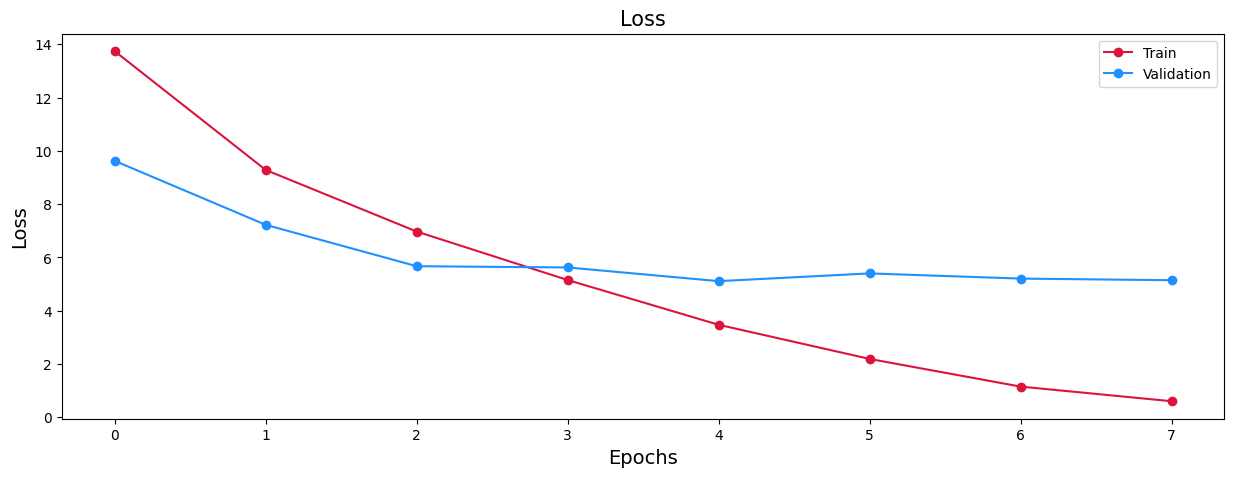

CPU times: user 13min 17s, sys: 3min 23s, total: 16min 40s
Wall time: 36min 3s


In [ ]:
%%time
from acsa_model import VLSP2018MultiTask
from helper import plot_training_history
model = VLSP2018MultiTask(PRETRAINED_MODEL, MULTI_BRANCH_NAMES, optimizer, multi_branch=True, name=MODEL_NAME)

history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history

model.save_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}', save_format='tf')
plot_training_history(history)

In [ ]:
from google.colab import drive # Move weights to Drive for faster downloading
drive.mount('/content/GoogleDrive', force_remount=True)
!zip -r ./weights/{MODEL_NAME}.zip ./weights/{MODEL_NAME}
!mv ./weights/{MODEL_NAME}.zip /content/GoogleDrive/My\ Drive

Mounted at /content/GoogleDrive
  adding: weights/Hotel-v2/ (stored 0%)
  adding: weights/Hotel-v2/Hotel-v2.index (deflated 80%)
  adding: weights/Hotel-v2/checkpoint (deflated 37%)
  adding: weights/Hotel-v2/Hotel-v2.data-00000-of-00001 (deflated 32%)


# Predict on the Test Data

In [ ]:
from acsa_model import VLSP2018MultiTask
reloaded_model = VLSP2018MultiTask(PRETRAINED_MODEL, MULTI_BRANCH_NAMES, optimizer, multi_branch=True, name=MODEL_NAME)
reloaded_model.load_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}') # Reload the Model
reloaded_model.evaluate(val_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


80/80 [==============================] - 86s 424ms/step - loss: 5.1088 - output_1_loss: 0.0367 - output_2_loss: 0.1527 - output_3_loss: 0.2799 - output_4_loss: 0.0947 - output_5_loss: 0.0225 - output_6_loss: 0.0689 - output_7_loss: 0.1183 - output_8_loss: 0.0339 - output_9_loss: 0.0636 - output_10_loss: 0.1383 - output_11_loss: 0.1781 - output_12_loss: 0.0967 - output_13_loss: 0.4115 - output_14_loss: 0.2889 - output_15_loss: 0.2596 - output_16_loss: 0.2912 - output_17_loss: 0.1120 - output_18_loss: 0.0587 - output_19_loss: 0.1344 - output_20_loss: 0.1558 - output_21_loss: 0.3094 - output_22_loss: 0.3040 - output_23_loss: 0.1252 - output_24_loss: 0.0209 - output_25_loss: 0.0528 - output_26_loss: 0.0163 - output_27_loss: 0.1475 - output_28_loss: 0.2224 - output_29_loss: 0.3728 - output_30_loss: 0.0691 - output_31_loss: 0.0143 - output_32_loss: 0.0274 - output_33_loss: 0.1703 - output_34_loss: 0.2599


[5.108790874481201,
 0.03673272579908371,
 0.15272781252861023,
 0.2799302339553833,
 0.09465484321117401,
 0.02253132127225399,
 0.06891969591379166,
 0.11832165718078613,
 0.03387727588415146,
 0.06358958780765533,
 0.1383306235074997,
 0.17808552086353302,
 0.09666352719068527,
 0.41152477264404297,
 0.2889023721218109,
 0.25963708758354187,
 0.2911686599254608,
 0.11199065297842026,
 0.058713965117931366,
 0.1343611776828766,
 0.15583424270153046,
 0.3094068169593811,
 0.3039516806602478,
 0.12519752979278564,
 0.02088087610900402,
 0.052822794765233994,
 0.016273751854896545,
 0.14752714335918427,
 0.22244851291179657,
 0.372786283493042,
 0.06910847127437592,
 0.014304871670901775,
 0.027367204427719116,
 0.1703493893146515,
 0.25986722111701965]

In [ ]:
y_pred = reloaded_model.acsa_predict(test_tf_dataset, BATCH_SIZE) # On test set
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
print('Example:', raw_datasets['test'][0]['Review'])
reloaded_model.print_acsa_pred(y_pred[0])

24/24 [==============================] - 37s 443ms/step - loss: 6.2687 - output_1_loss: 0.0287 - output_2_loss: 0.1693 - output_3_loss: 0.3066 - output_4_loss: 0.1179 - output_5_loss: 0.0782 - output_6_loss: 0.0791 - output_7_loss: 0.2068 - output_8_loss: 0.0360 - output_9_loss: 0.0672 - output_10_loss: 0.1520 - output_11_loss: 0.2170 - output_12_loss: 0.1274 - output_13_loss: 0.3098 - output_14_loss: 0.1856 - output_15_loss: 0.3243 - output_16_loss: 0.4970 - output_17_loss: 0.1518 - output_18_loss: 0.0707 - output_19_loss: 0.1714 - output_20_loss: 0.2473 - output_21_loss: 0.3087 - output_22_loss: 0.4272 - output_23_loss: 0.3001 - output_24_loss: 0.0610 - output_25_loss: 0.1028 - output_26_loss: 0.0692 - output_27_loss: 0.1945 - output_28_loss: 0.1986 - output_29_loss: 0.4088 - output_30_loss: 0.0897 - output_31_loss: 0.0374 - output_32_loss: 0.0137 - output_33_loss: 0.2624 - output_34_loss: 0.2506
Example: Ga giường không sạch, nhân viên quên dọn phòng một ngày.
=> ROOMS#CLEANLI

In [ ]:
from tensorflow.data import Dataset # On a random review by user
random_input = VLSP2018Loader.preprocess_and_tokenize(
    input('Enter your review: '), vn_preprocessor, tokenizer,
    batch_size=1, max_length=MAX_LENGTH
)
tf_inputs = Dataset.from_tensor_slices({x: [[random_input[x][0]]] for x in tokenizer.model_input_names})
random_pred = reloaded_model.acsa_predict(tf_inputs)
reloaded_model.print_acsa_pred(random_pred[0])

Enter your review: đồ ăn ngon, dịch vụ chưa được sạch sẽ lắm, còn thiếu tiện nghi, cảnh đẹp
[INFO] Preprocessing and tokenizing text data...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/1 [==============================] - 8s 8s/step
=> FOOD&DRINKS#QUALITY,positive
=> HOTEL#CLEANLINESS,positive


# Scikit-learn Evaluation

In [ ]:
y_test = preprocessed_datasets['test'].remove_columns(tokenizer.model_input_names)
y_test = y_test.to_pandas().to_numpy()
y_test

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from evaluators.sklearn_evaluator import VLSP2018SklearnEvaluator
sk_eval = VLSP2018SklearnEvaluator(y_test, y_pred, list(MULTI_BRANCH_NAMES))
# sk_eval.report(report_type='Aspect#Category,Polarity').round(3)
# sk_eval.report(report_type='Aspect#Category').round(3)
# sk_eval.report(report_type='Polarity').round(3)
# sk_eval.report(report_type='macro_avg').round(3)
sk_eval.report(report_type='all')

100%|██████████| 37/37 [00:00<00:00, 38777.92it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 FACILITIES#CLEANLINESS,positive 
 1.000 0.600 0.750 5 
 1.000 0.500 0.667 2 
 
 
 
 FACILITIES#CLEANLINESS,negative 
 
 1.000 0.667 0.800 3 
 
 
 
 FACILITIES#COMFORT,positive 
 0.000 0.000 0.000 26 
 0.000 0.000 0.000 20 
 
 
 
 FACILITIES#COMFORT,negative 
 
 1.000 0.000 0.000 6 
 
 
 
 FACILITIES#DESIGN&FEATURES,positive 
 0.828 0.369 0.511 65 
 0.750 0.237 0.360 38 
 
 
 
 FACILITIES#DESIGN&FEATURES,neutral 
 
 1.000 0.000 0.000 5 
 
 
 
 FACILITIES#DESIGN&FEATURES,negative 
 
 0.529 0.409 0.462 22 
 
 
 
 FACILITIES#GENERAL,positive 
 0.692 0.429 0.529 21 
 0.615 0.421 0.500 19 
 
 
 
 FACILITIES#GENERAL,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 FACILITIES#GENERAL,negative 
 
 1.000 0.000 0.000 1 
 
 
 
 FACILITIES#MISCELLANEOUS,positive 
 1.000 0.000 0.000 8 
 1.000 0.000 0.000 3 
 
 
 
 FACILITIES#MISCELLANEOUS,negative 
 
 1.000 0.000 0.000 5 
 
 
 
 FACILITIES#PRICES,positive 
 0.200 0.077 0.111 13 
 0.333 0.125 0.182 8 
 
 
 
 FACILITIES#PRICES,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#PRICES,negative 
 
 0.000 0.000 0.000 3 
 
 
 
 FACILITIES#QUALITY,positive 
 0.889 0.471 0.615 51 
 1.000 0.125 0.222 24 
 
 
 
 FACILITIES#QUALITY,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#QUALITY,negative 
 
 0.708 0.680 0.694 25 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,positive 
 1.000 0.000 0.000 3 
 1.000 0.000 0.000 1 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,negative 
 
 1.000 0.000 0.000 2 
 
 
 
 FOOD&DRINKS#PRICES,positive 
 0.000 0.000 0.000 9 
 0.000 0.000 0.000 6 
 
 
 
 FOOD&DRINKS#PRICES,negative 
 
 0.000 0.000 0.000 3 
 
 
 
 FOOD&DRINKS#QUALITY,positive 
 0.974 0.876 0.922 129 
 0.931 0.979 0.954 96 
 
 
 
 FOOD&DRINKS#QUALITY,neutral 
 
 1.000 0.071 0.133 14 
 
 
 
 FOOD&DRINKS#QUALITY,negative 
 
 0.857 0.632 0.727 19 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,positive 
 0.920 0.831 0.873 124 
 0.833 0.814 0.824 43 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,neutral 
 
 1.000 0.000 0.000 6 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,negative 
 
 0.843 0.787 0.814 75 
 
 
 
 HOTEL#CLEANLINESS,positive 
 0.885 0.806 0.844 67 
 0.883 0.898 0.891 59 
 
 
 
 HOTEL#CLEANLINESS,negative 
 
 1.000 0.125 0.222 8 
 
 
 
 HOTEL#COMFORT,positive 
 0.775 0.585 0.667 94 
 0.779 0.662 0.716 80 
 
 
 
 HOTEL#COMFORT,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 HOTEL#COMFORT,negative 
 
 0.000 0.000 0.000 13 
 
 
 
 HOTEL#DESIGN&FEATURES,positive 
 0.805 0.824 0.814 85 
 0.783 0.878 0.828 74 
 
 
 
 HOTEL#DESIGN&FEATURES,neutral 
 
 0.000 0.000 0.000 3 
 
 
 
 HOTEL#DESIGN&FEATURES,negative 
 
 0.333 0.125 0.182 8 
 
 
 
 HOTEL#GENERAL,positive 
 0.822 0.795 0.808 151 
 0.793 0.822 0.807 135 
 
 
 
 HOTEL#GENERAL,neutral 
 
 1.000 0.000 0.000 4 
 
 
 
 HOTEL#GENERAL,negative 
 
 0.833 0.417 0.556 12 
 
 
 
 HOTEL#MISCELLANEOUS,positive 
 1.000 0.059 0.111 68 
 1.000 0.000 0.000 29 
 
 
 
 HOTEL#MISCELLANEOUS,neutral 
 
 1.000 0.000 0.000 5 
 
 
 
 HOTEL#MISCELLANEOUS,negative 
 
 0.750 0.088 0.158 34 
 
 
 
 HOTEL#PRICES,positive 
 0.847 0.704 0.769 71 
 0.821 0.730 0.773 63 
 
 
 
 HOTEL#PRICES,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 HOTEL#PRICES,negative 
 
 0.333 0.167 0.222 6 
 
 
 
 HOTEL#QUALITY,positive 
 0.625 0.385 0.476 13 
 0.500 0.429 0.462 7 
 
 
 
 HOTEL#QUALITY,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 HOTEL#QUALITY,negative 
 
 0.500 0.200 0.286 5 
 
 
 
 LOCATION#GENERAL,positive 
 0.964 0.959 0.961 221 
 0.925 0.968 0.946 190 
 
 
 
 LOCATION#GENERAL,neutral 
 
 0.500 0.067 0.118 15 
 
 
 
 LOCATION#GENERAL,negative 
 
 0.632 0.750 0.686 16 
 
 
 
 ROOMS#CLEANLINESS,positive 
 0.889 0.925 0.907 200 
 0.870 0.964 0.914 166 
 
 
 
 ROOMS#CLEANLINESS,neutral 
 
 1.000 0.000 0.000 7 
 
 
 
 ROOMS#CLEANLINESS,negative 
 
 0.750 0.667 0.706 27 
 
 
 
 ROOMS#COMFORT,positive 
 0.627 0.796 0.701 93 
 0.557 0.900 0.688 60 
 
 
 
 ROOMS#COMFORT,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 ROOMS#COMFORT,ne

# VLSP Evaluation

In [ ]:
from processors.vlsp2018_processor import VLSP2018Parser
VLSP2018Parser.vlsp_save_as(f'./predictions/{MODEL_NAME}.txt', raw_datasets['test']['Review'], y_pred, MULTI_BRANCH_NAMES)
!java ../evaluators/SAEvaluate.java {TEST_PATH.replace('.csv', '.txt')} ./predictions/{MODEL_NAME}.txt

600it [00:00, 63669.04it/s]


Row mismatch:﻿#1 <-> #1
Evaluation Result >> File:./predictions/Hotel-v2.txt<> [../datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.txt]
                    Gold count	46	416	200	93	221	57	198	67	68	144	32	124	10	65	85	51	13	71	151	29	94	21	68	59	8	26	129	3	13	9	5	4	3	1
                  ANSWER count	42	412	208	118	220	13	195	61	45	104	22	112	1	29	87	27	8	59	146	21	71	13	4	27	0	1	116	0	5	4	3	0	0	0

        Correct ANSWER: aspect	23	404	185	74	212	12	171	54	38	85	19	103	1	24	70	24	5	50	120	16	55	9	4	15	0	0	113	0	1	0	3	0	0	0
             Precision: aspect	0.5476	0.9806	0.8894	0.6271	0.9636	0.9231	0.8769	0.8852	0.8444	0.8173	0.8636	0.9196	1.0000	0.8276	0.8046	0.8889	0.6250	0.8475	0.8219	0.7619	0.7746	0.6923	1.0000	0.5556	0.0000	0.0000	0.9741	0.0000	0.2000	0.0000	1.0000	0.0000	0.0000	0.0000
                Recall: aspect	0.5000	0.9712	0.9250	0.7957	0.9593	0.2105	0.8636	0.8060	0.5588	0.5903	0.5938	0.8306	0.1000	0.3692	0.8235	0.4706	0.3846	0.7042	0.7947	0.5517	0.5851	0.4286	0.0588	0.2542	0.0